# This code supports part 2 of Time Series Forecasting 

## 1) Import and load data

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, concat
import glob

In [2]:
locn = "C:\\Users\\rangy\\Downloads\\hyddata\\features\\*.txt"
# find all the txt files in the path 
files = glob.glob(locn)
# use a dict to save all the variables 
features = {}

In [3]:
for name in files:
    try:
        with open(name) as f:
            # read in the data 
            temp_df = pd.read_csv(name,delim_whitespace=True,header=None)
            # make the row names cycle as a variable
            temp_df.index.name = 'cycle'
            temp_df.reset_index(inplace=True)
            # transpose the data 
            temp_df_transposed= temp_df.T
            # make the seconds a variable, call it "time”
            temp_df_transposed.index.name = 'time'
            temp_df_transposed.reset_index(inplace=True)
            # add a prefix cycle in the column names to help with pivoting data (from wide to long)
            string = ' cycle'.join(str(e) for e in list(temp_df_transposed.columns))
            temp_df_transposed.columns = string.split(" ")
            # From wide to long to help with joining all the variables 
            temp_df_long = pd.wide_to_long(temp_df_transposed.iloc[1:,:],stubnames='cycle', i=['time'], j='c')
            temp_df_long.reset_index(inplace=True)
            # save each data variable in the long format into separate data frames in the dictionary called "features"
            # but exclude path and txt in the names
            features[name[9:-4]] = temp_df_long
                        
           
    
    # prevent a possible error
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            raise

In [4]:
label = pd.read_csv("C:\\Users\\rangy\\Downloads\\hyddata\\profile.txt",delim_whitespace=True,header=None)
label.columns = ['cooler_condition', 'valve_condition', 'pump_leak', 'hydraulic_accumulator', 'stable_flag']

In [5]:
for key in list(features.keys()):
    features[key].columns=['seconds','cycle',key]

In [6]:
dfs= [features['rangy\\Downloads\\hyddata\\features\\CE'],
      features['rangy\\Downloads\\hyddata\\features\\CP'],
      features['rangy\\Downloads\\hyddata\\features\\EPS1'],
      features['rangy\\Downloads\\hyddata\\features\\FS1'],
      features['rangy\\Downloads\\hyddata\\features\\FS2'],
      features['rangy\\Downloads\\hyddata\\features\\PS1'],
      features['rangy\\Downloads\\hyddata\\features\\PS2'],
      features['rangy\\Downloads\\hyddata\\features\\PS3'],
      features['rangy\\Downloads\\hyddata\\features\\PS4'],
      features['rangy\\Downloads\\hyddata\\features\\PS5'],
      features['rangy\\Downloads\\hyddata\\features\\PS6'],
      features['rangy\\Downloads\\hyddata\\features\\SE'],
      features['rangy\\Downloads\\hyddata\\features\\TS1'],
      features['rangy\\Downloads\\hyddata\\features\\TS2'],
      features['rangy\\Downloads\\hyddata\\features\\TS3'],
      features['rangy\\Downloads\\hyddata\\features\\TS4'],
      features['rangy\\Downloads\\hyddata\\features\\VS1']]

In [7]:
from functools import reduce
features_join = reduce(lambda left,right: pd.merge(left,right,on=['seconds','cycle']), dfs)

In [8]:
label.columns

Index(['cooler_condition', 'valve_condition', 'pump_leak',
       'hydraulic_accumulator', 'stable_flag'],
      dtype='object')

## 2) Evaluate autocorrelation plots to discern lag 

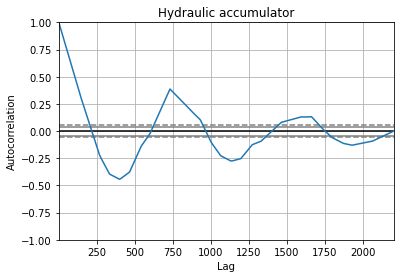

In [9]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot

autocorrelation_plot(label['hydraulic_accumulator'])
pyplot.title('Hydraulic accumulator')
pyplot.show()

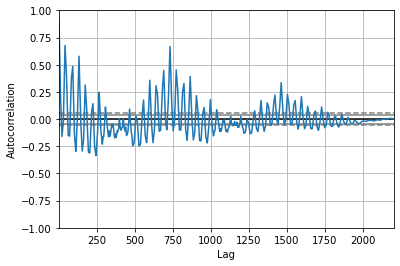

In [10]:
autocorrelation_plot(label['valve_condition'])
pyplot.show()

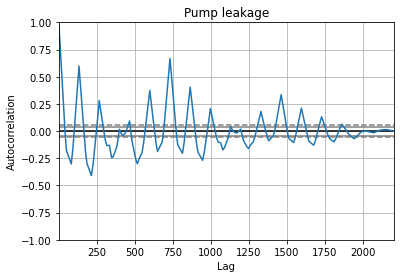

In [11]:
autocorrelation_plot(label['pump_leak'])
pyplot.title('Pump leakage')
pyplot.show()

## 3) Import and fit ARIMA

In [14]:
from statsmodels.tsa.arima.model import ARIMA

In [15]:
label_train, label_test = label.loc[:1000,:], label.loc[1001:,:]

In [16]:
hydmodel = ARIMA(label_train['hydraulic_accumulator'],order=(100,0,0))
hydmodel_fit = hydmodel.fit()

<AxesSubplot:ylabel='Density'>

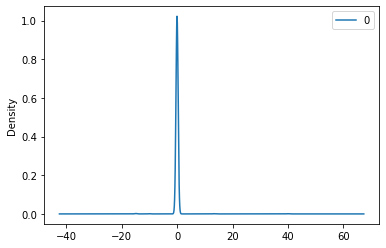

In [17]:
resids = DataFrame(hydmodel_fit.resid)
resids.plot(kind='kde')

In [18]:
resids.describe()

,0
count,1001.000000
mean,-0.008357
std,1.523301
min,-15.007168
25%,-0.089899
50%,-0.016426
75%,0.050638
max,39.892876


In [19]:
label_train_hyd = label_train['hydraulic_accumulator']
label_test_hyd = label_test['hydraulic_accumulator']

label_train_leak = label_train['pump_leak']
label_test_leak = label_test['pump_leak']

In [20]:
label_test_hydr = label_test_hyd[:100].values

In [21]:
leakmodel = ARIMA(label_train['pump_leak'],order=(50,0,0))
leakmodel_fit = leakmodel.fit()

In [22]:
preds = hydmodel_fit.forecast(100)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(label_test_hyd[:100].values,preds)


5.497039364116949

In [23]:
leakpreds = leakmodel_fit.forecast(100)
mean_absolute_error(label_test_leak[:100].values,leakpreds)

0.6483865166956349


# AutoML using H2O.ai

In [24]:
%pip install h2o
import h2o
from h2o.automl import H2OAutoML

Note: you may need to restart the kernel to use updated packages.


In [25]:
h2o.init(ip="127.0.0.1", port="8080")

Checking whether there is an H2O instance running at http://127.0.0.1:8080 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.281-b09, mixed mode)
  Starting server from C:\Users\rangy\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\rangy\AppData\Local\Temp\tmpfhttrgtz
  JVM stdout: C:\Users\rangy\AppData\Local\Temp\tmpfhttrgtz\h2o_rangy_started_from_python.out
  JVM stderr: C:\Users\rangy\AppData\Local\Temp\tmpfhttrgtz\h2o_rangy_started_from_python.err
  Server is running at http://127.0.0.1:8080
Connecting to H2O server at http://127.0.0.1:8080 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.3
H2O_cluster_version_age:,1 month and 6 days
H2O_cluster_name:,H2O_from_python_rangy_l1xh49
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.630 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


In [26]:
%pip install tsfresh
from tsfresh import select_features
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_relevant_features

# Automatic feautre extraction using the tsfresh package
extracted_features = extract_features(features_join, column_id="cycle", column_sort="seconds")
# Impute any possible missing values 
impute(extracted_features)


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 15/15 [11:38<00:00, 46.55s/it]
C:\Users\rangy\anaconda3\lib\site-packages\tsfresh\utilities\dataframe_functions.py:171: RuntimeWarning: The columns ['rangy\\Downloads\\hyddata\\features\\CE__fft_coefficient__attr_"real"__coeff_31'
 'rangy\\Downloads\\hyddata\\features\\CE__fft_coefficient__attr_"real"__coeff_32'
 'rangy\\Downloads\\hyddata\\features\\CE__fft_coefficient__attr_"real"__coeff_33'
 ...
 'rangy\\Downloads\\hyddata\\features\\VS1__fft_coefficient__attr_"angle"__coeff_97'
 'rangy\\Downloads\\hyddata\\features\\VS1__fft_coefficient__attr_"angle"__coeff_98'
 'rangy\\Downloads\\hyddata\\features\\VS1__fft_coefficient__attr_"angle"__coeff_99'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


,rangy\Downloads\hyddata\features\CE__variance_larger_than_standard_deviation,rangy\Downloads\hyddata\features\CE__has_duplicate_max,rangy\Downloads\hyddata\features\CE__has_duplicate_min,rangy\Downloads\hyddata\features\CE__has_duplicate,rangy\Downloads\hyddata\features\CE__sum_values,rangy\Downloads\hyddata\features\CE__abs_energy,rangy\Downloads\hyddata\features\CE__mean_abs_change,rangy\Downloads\hyddata\features\CE__mean_change,rangy\Downloads\hyddata\features\CE__mean_second_derivative_central,rangy\Downloads\hyddata\features\CE__median,...,rangy\Downloads\hyddata\features\VS1__fourier_entropy__bins_2,rangy\Downloads\hyddata\features\VS1__fourier_entropy__bins_3,rangy\Downloads\hyddata\features\VS1__fourier_entropy__bins_5,rangy\Downloads\hyddata\features\VS1__fourier_entropy__bins_10,rangy\Downloads\hyddata\features\VS1__fourier_entropy__bins_100,rangy\Downloads\hyddata\features\VS1__permutation_entropy__dimension_3__tau_1,rangy\Downloads\hyddata\features\VS1__permutation_entropy__dimension_4__tau_1,rangy\Downloads\hyddata\features\VS1__permutation_entropy__dimension_5__tau_1,rangy\Downloads\hyddata\features\VS1__permutation_entropy__dimension_6__tau_1,rangy\Downloads\hyddata\features\VS1__permutation_entropy__dimension_7__tau_1
0,1.0,0.0,0.0,1.0,2376.081,96490.454613,0.330644,-0.310780,-0.004241,40.6755,...,0.239217,0.239217,0.424254,0.563420,1.367099,1.686006,2.644019,3.421882,3.711047,3.860623
1,1.0,0.0,0.0,1.0,1547.186,40064.147542,0.229559,-0.095254,0.005638,25.3855,...,0.142506,0.142506,0.457102,0.595073,1.433575,1.595254,2.462080,3.107687,3.498105,3.727584
2,0.0,0.0,0.0,1.0,1333.094,29643.035132,0.181305,-0.034492,0.002319,22.1040,...,0.142506,0.142506,0.379535,0.379535,1.807218,1.664222,2.716036,3.427950,3.760199,3.886296
3,0.0,0.0,0.0,1.0,1227.589,25128.500929,0.196085,-0.019271,-0.000431,20.4805,...,0.142506,0.142506,0.283936,0.595073,1.061467,1.700625,2.632835,3.357998,3.675070,3.850934
4,0.0,0.0,0.0,1.0,1187.221,23496.528969,0.172678,-0.007525,0.001733,19.7985,...,0.142506,0.142506,0.283936,0.424254,1.705525,1.772589,2.863561,3.542382,3.821382,3.963312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.0,0.0,0.0,1.0,2797.711,130456.449601,0.146136,-0.007051,0.002155,46.6335,...,0.142506,0.142506,0.283936,0.424254,1.220532,1.679611,2.719164,3.333242,3.695355,3.860623
2201,0.0,0.0,0.0,1.0,2801.389,130805.448029,0.131864,0.004271,-0.000250,46.6510,...,0.142506,0.283936,0.283936,0.518700,1.192692,1.638909,2.554651,3.198601,3.701534,3.860623
2202,0.0,0.0,0.0,1.0,2788.338,129593.101044,0.129576,-0.004322,0.001940,46.7005,...,0.239217,0.283936,0.283936,0.424254,1.518855,1.708797,2.782633,3.468116,3.805690,3.911968
2203,0.0,1.0,0.0,1.0,2792.698,129989.496364,0.155017,-0.000237,0.000914,46.5490,...,0.239217,0.283936,0.283936,0.283936,1.147973,1.738131,2.780204,3.485050,3.755280,3.911968


In [28]:
combined_extracted = extracted_features.join(label)
combined_extracted.reset_index(inplace=True)

train_extracted = combined_extracted.iloc[:1100,:]
test_extracted = combined_extracted.iloc[1101:,:]

hf_train_extracted = h2o.H2OFrame(train_extracted)
hf_test_extracted = h2o.H2OFrame(test_extracted)

y = 'hydraulic_accumulator'
X = hf_train_extracted.columns
X.remove(y)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


### Evaluating h2O Auto ML model performance

In [30]:
aml_search_hyd = H2OAutoML(max_runtime_secs = 600)

aml_search_hyd.train(x = X, 
          y = y,
          training_frame = hf_train_extracted,
          leaderboard_frame = hf_test_extracted)

aml_search_hyd.leaderboard

AutoML progress: |
07:03:50.114: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_5_AutoML_20210131_070349,239.608,15.4793,239.608,13.4257,0.149165
GBM_4_AutoML_20210131_070349,247.138,15.7206,247.138,14.0689,0.150895
GBM_grid__1_AutoML_20210131_070349_model_1,251.615,15.8624,251.615,13.482,0.15228
GBM_1_AutoML_20210131_070349,253.06,15.9079,253.06,13.919,0.153112
GBM_2_AutoML_20210131_070349,266.119,16.3132,266.119,14.5361,0.156282
GBM_3_AutoML_20210131_070349,268.968,16.4003,268.968,14.5575,0.157352
DRF_1_AutoML_20210131_070349,274.663,16.573,274.663,13.8949,0.155626
GBM_grid__1_AutoML_20210131_070349_model_2,277.101,16.6463,277.101,14.849,0.159419
StackedEnsemble_BestOfFamily_AutoML_20210131_070349,283.263,16.8304,283.263,15.1398,0.161034
StackedEnsemble_AllModels_AutoML_20210131_070349,283.754,16.845,283.754,15.1481,0.161171


In [32]:
yleak = 'pump_leak'

aml_search_pump = H2OAutoML(max_runtime_secs = 600)

aml_search_pump.train(x = X, 
          y = yleak,
          training_frame = hf_train_extracted,
          leaderboard_frame = hf_test_extracted)

aml_search_pump.leaderboard

AutoML progress: |
07:18:28.311: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid__1_AutoML_20210131_071828_model_1,0.0336767,0.183512,0.0336767,0.132982,0.106448
DRF_1_AutoML_20210131_071828,0.110127,0.331854,0.110127,0.219203,0.226125
XRT_1_AutoML_20210131_071828,0.155557,0.394407,0.155557,0.262034,0.271175
GBM_5_AutoML_20210131_071828,0.225405,0.474768,0.225405,0.423485,0.280952
GBM_1_AutoML_20210131_071828,0.304377,0.551703,0.304377,0.483328,0.31558
GBM_3_AutoML_20210131_071828,0.320224,0.565884,0.320224,0.49614,0.320502
GBM_2_AutoML_20210131_071828,0.359336,0.599446,0.359336,0.522027,0.335224
GBM_4_AutoML_20210131_071828,0.401258,0.633449,0.401258,0.562224,0.366969
GBM_grid__1_AutoML_20210131_071828_model_2,0.551699,0.742764,0.551699,0.658109,0.416611
StackedEnsemble_BestOfFamily_AutoML_20210131_071828,0.685,0.827647,0.685,0.737183,0.466706


In [ ]:
best_performer = extracted_aml_searcher.leader

import pickle
pickle.dump(best_performer, open('best automl', 'wb'))